In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from functools import partial
from scipy.stats import f, ncf

### Algorithm

**Step 1** : Fit the tree model with varying ccp_alpha hyperparameter value  
> *Step 1-a (Optional) : Using agglomerative clustering, reduce further dimension (and control the number of final nodes or leaves)*   

**Step 2** : For each models, find the confidence interval for tau and reduce dimensionality upto the point where lower bound of the tau exceeds the threshold   
**Step 3** : With the selected model, we find the linear space where the null hypothesis were not rejected => Find uneffective interaction terms   

# Discussions

## 1. Order of variables and Tree Model

Here, we assume the order of binary variables would matter when fitting the tree model.   
We are going to test how they differently perform based on the order.   
There are three selected ways of ordering the binary variables X_0, X_1, ..., X_p   
* No order : It is randomized order
* By variance of each X : We place the variable that has the largest variance and place the nexts
* By covariance : (check below)

#### Ordering variables by covariance

Suppose we have a covariance matrix $\in Mat_{p x p}(R)$.   
Then we can eigen decompose with eigenvalues greater than or equal to 0 and a set of eigenvectors orthogoal to each other, because the covariance as covariance is always a semi-positive definite matrix.   
Then we select **k** number of largest eigenvalues where k is defined as $argmin_k(\Sigma_{i = 1}^k \lambda_i > 0.8 \cdot \Sigma_{i = 1}^p \lambda_i)$.   
0.8 is chosen as it is the number generally used in variable selection with the PCA.
<br><br>
Let {$p_1$, ..., $p_k$} be a set of the corresponding eigenvectors for $\lambda_i$. Let $P^* = [p_1, ..., p_k] \in Mat_{p x k}(R)$ and $\Lambda^* = diag(\lambda_1, ..., \lambda_k)$.   
Then $\|e_i - [P^* \cdot (P^{*t} \Lambda^* P^*)^{-1} \cdot P^{*t}] \cdot e_i\|$, where $e_i$ is a standard unit vector with $i^{th}$ element is 1, indicates how much variablity each binary variables $X_i$ explains.   
When $k = p$, it will be measured simply by $[COV^{-1} ]\cdot e_i$.

#### How to compare

As ccp_alpha increases, the number of segments is going to decrease. As it decreases, we may observe decrease in $R^2$ and this implies that we can measure the loss of information using $\hat{\tau} = \frac{R^2_{full} - R^2_{reduced}}{1-R^2_{full}}$. What we may observe, assuming each approach results in differences in their performance, is $\hat{tau}$ increases slower if the approach experiences more efficiency. In other words, as the number of final nodes or leaves reduces, it may experience more dramatic decrease in $R^2$

#### Experiment: with p = 5, how the order is different

In [8]:
variable_index_var = []
variable_index_cov = []
original_index_var = []
original_index_cov = []

In [9]:
rg.rng.sample(range(5), 5)

[3, 4, 2, 1, 0]

In [1]:
# for i in range(1000):
#     rg = RandomGenerator(5, 200, order_by = 'var', use_dask = False)
#     rg.reorder(by = 'cov')
#     variable_index_var += [z + rg.rng.uniform(-.1, .1) for z in range(5)]
#     original_index_var += list(range(5))
#     variable_index_cov += [int(z[-1]) + rg.rng.uniform(-.1, .1) for z in rg._X.columns[:5].tolist()]
#     original_index_cov += [int(z[-1]) for z in rg._X.columns[:5].tolist()]

In [11]:
df_plot = pd.DataFrame({"by_variance": variable_index_var,
                       "by_covariance": variable_index_cov,
                       "var_order": original_index_var,
                       "cov_order": original_index_cov})

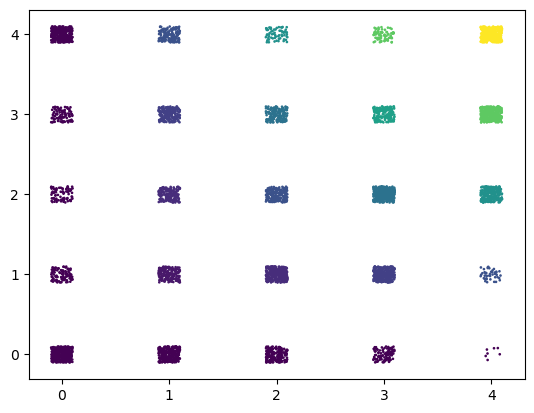

In [25]:
fig, ax = plt.subplots()
ax.scatter(df_plot.by_variance, df_plot.by_covariance, c = df_plot.var_order*df_plot.cov_order, s = .8)
plt.show()

In [27]:
plt.savefig(fname = 'order_plot1', format = 'svg')

<Figure size 640x480 with 0 Axes>

In [13]:
freq = df_plot[['var_order','cov_order']].value_counts().reset_index().rename(columns = {0:'count'}).pivot_table(index = 'var_order',columns = 'cov_order')
freq

count                    
cov_order     0    1    2    3    4
var_order                          
0           365  101   82  100  352
1           311  182  158  194  155
2           209  351  198  177   65
3           108  323  322  173   74
4             7   44  246  359  344

#### Heatmap of the frequency table

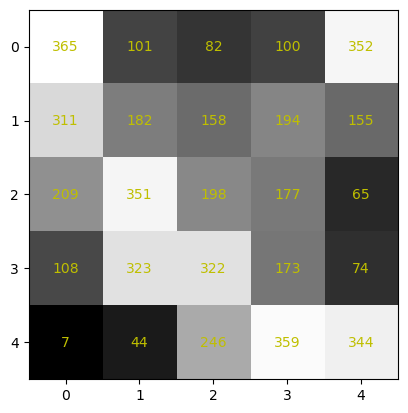

In [28]:
fig, ax = plt.subplots()
ax.imshow(freq.to_numpy(), cmap = 'gray')
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, freq.to_numpy()[i, j],
                       ha="center", va="center", color="y")
plt.show()

In [29]:
plt.savefig(fname = 'order_plot2', format = 'svg')

<Figure size 640x480 with 0 Axes>

What we can observe from the plot above is that the order by variance of each variable is not necessarily the same as the order by covariance

#### Experiment : Speed of increment in $\hat{\tau}$ between each ordering method

In [2]:
# rg = RandomGenerator(10, 10000, order_by = 'var', use_dask = False)

In [9]:
X_var = rg._X.apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
print(f"We have {2**10 - np.unique(X_var).shape[0]} number of missing pairs")

We have 71 number of missing pairs


In [10]:
X_cov = rg.reorder(by = 'cov').apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
print(f"new order is {rg._X.columns.to_list()}")

new order is ['X_9', 'X_8', 'X_7', 'X_1', 'X_0', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6']


In [11]:
X_ran = rg.reorder(by = 'random').apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
print(f"new order is {rg._X.columns.to_list()}")

new order is ['X_0', 'X_4', 'X_6', 'X_3', 'X_9', 'X_1', 'X_8', 'X_5', 'X_2', 'X_7']


In [12]:
y = rg()['y'].to_numpy().reshape(-1,1)

#### Comparing distribution of decimal value for the barcode variables depending on the order

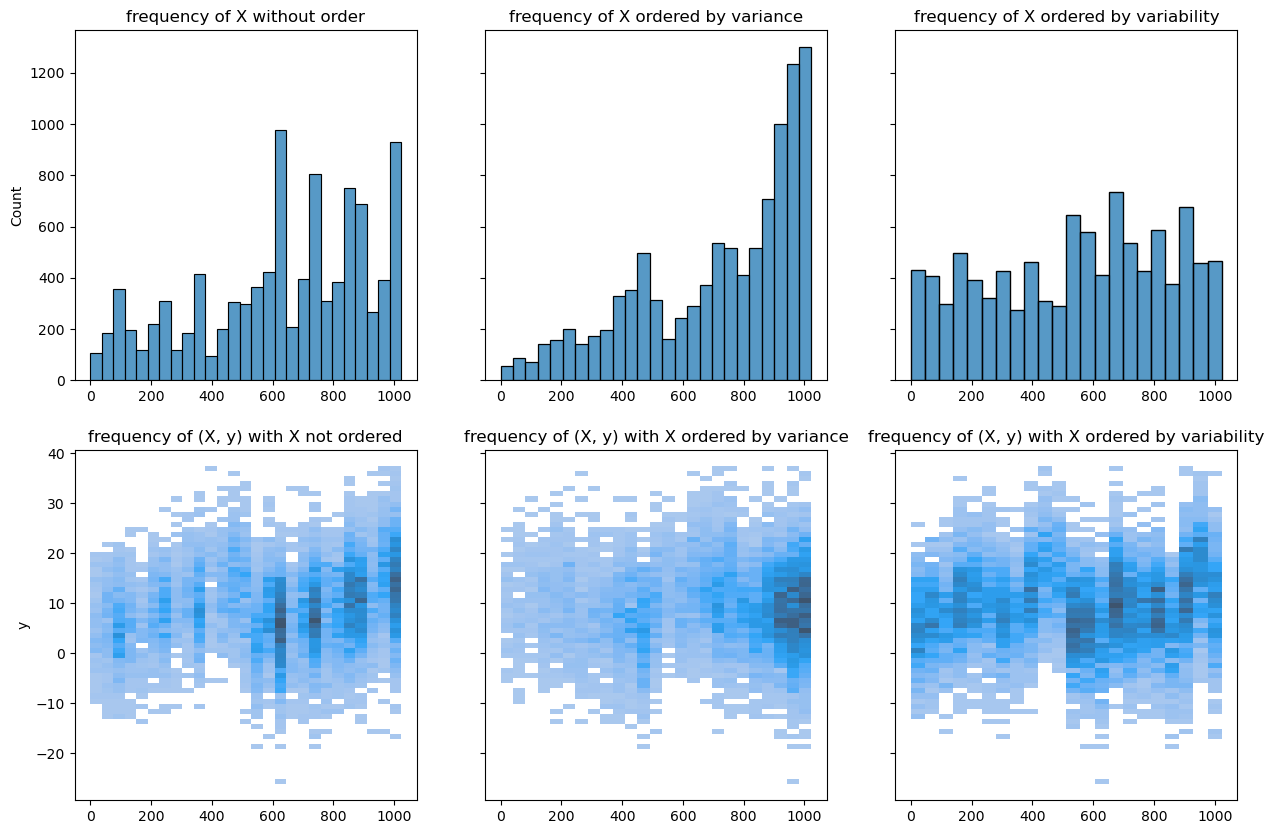

In [9]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10), sharey = 'row')
sns.histplot(x = X_ran.reshape(-1), ax = ax[0,0])
ax[0,0].set_title('frequency of X without order')
sns.histplot(x = X_var.reshape(-1), ax = ax[0,1])
ax[0,1].set_title('frequency of X ordered by variance')
sns.histplot(x = X_cov.reshape(-1), ax = ax[0,2])
ax[0,2].set_title('frequency of X ordered by variability')
sns.histplot(x = X_ran.reshape(-1), y = y.reshape(-1), ax = ax[1,0])
ax[1, 0].set_ylabel('y')
ax[1, 0].set_title('frequency of (X, y) with X not ordered')
sns.histplot(x = X_var.reshape(-1), y = y.reshape(-1), ax = ax[1,1])
ax[1, 1].set_title('frequency of (X, y) with X ordered by variance')
sns.histplot(x = X_cov.reshape(-1), y = y.reshape(-1), ax = ax[1,2])
ax[1, 2].set_title('frequency of (X, y) with X ordered by variability')
plt.show()

In [10]:
plt.savefig(fname = 'order_plot3', format = 'svg')

<Figure size 640x480 with 0 Axes>

#### Experiment: when max_leaf_nodes are set at the number of true parameters, which order scheme gives highest $R^2$

Condition:
* number of binary variables = 10
* size of dataset = 10,000
* number of sampling = 1000

In [2]:
from utils import *
from joblib import Parallel, delayed
from dataclasses import dataclass

In [3]:
def run_sim():
    rg = RandomGenerator(10, 15_000, order_by = 'var', use_dask = False, verbose= False)
    X_var = rg._X.apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    X_cov = rg.reorder(by = 'cov').apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    X_ran = rg.reorder(by = 'random').apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
    y = rg()['y'].to_numpy().reshape(-1,1)
    tree = tree_fit_result(10, 0.05, max_leaf_nodes = rg.config.parameter_size)
    ccp_alpha = None
    result = [test_result(), test_result(), test_result()]
    result[0].append_result(ccp_alpha = ccp_alpha, **tree(X_var, y))
    result[1].append_result(ccp_alpha = ccp_alpha, **tree(X_cov, y))
    result[2].append_result(ccp_alpha = ccp_alpha, **tree(X_ran, y))
    return result

In [4]:
res = Parallel(n_jobs = -1, verbose = 1)(
    delayed(run_sim)() for _ in range(1000)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.6min finished


In [5]:
result_var = sum([result[0] for result in res])
result_cov = sum([result[1] for result in res])
result_ran = sum([result[2] for result in res])

In [7]:
result = pd.DataFrame(zip(result_ran.r_squared_reduced, result_cov.r_squared_reduced, result_var.r_squared_reduced,
                         result_ran.tau_estimates, result_cov.tau_estimates, result_var.tau_estimates), 
                      columns = ['rsq_random','rsq_cov','rsq_var','tau_random','tau_cov','tau_var'])
result['var_minus_random'] = result.rsq_var - result.rsq_random
result['cov_minus_random'] = result.rsq_cov - result.rsq_random
result['cov_minus_var']    = result.rsq_cov - result.rsq_var
result['tau_var_minus_random'] = result.tau_var - result.tau_random
result['tau_cov_minus_var'] = result.tau_cov - result.tau_var
result['tau_cov_minus_random'] = result.tau_cov - result.tau_random

In [8]:
result.var_minus_random.mean(), result.cov_minus_random.mean(), result.cov_minus_var.mean()

(0.0031607295863809596, 0.0009136262258077109, -0.0022471033605732525)

In [12]:
result.var_minus_random.median(), result.cov_minus_random.median(), result.cov_minus_var.median()

(0.004571956767486285, -0.0006756245750696999, -0.003661119251116285)

In [9]:
result.tau_var_minus_random.mean(), result.tau_cov_minus_random.mean(), result.tau_cov_minus_var.mean()

(-0.0068966000005248876, -0.0025355844693720517, 0.004361015531152835)

In [14]:
result.head()

,rsq_random,rsq_cov,rsq_var,tau_random,tau_cov,tau_var,var_minus_random,cov_minus_random,cov_minus_var,tau_var_minus_random,tau_cov_minus_var,tau_cov_minus_random
0,0.148653,0.151710,0.160743,0.198378,0.194076,0.181361,0.012089,0.003056,-0.009033,-0.017017,0.012715,-0.004302
1,0.436523,0.423445,0.465327,0.537493,0.573179,0.458899,0.028804,-0.013079,-0.041883,-0.078594,0.114280,0.035686
2,0.159933,0.154606,0.145266,0.169133,0.176547,0.189545,-0.014667,-0.005327,0.009339,0.020412,-0.012998,0.007414
3,0.279193,0.266061,0.277794,0.262528,0.285529,0.264978,-0.001399,-0.013132,-0.011733,0.002450,0.020551,0.023001
4,0.326030,0.342578,0.381577,0.489470,0.452900,0.366712,0.055547,0.016548,-0.038999,-0.122758,0.086188,-0.036571


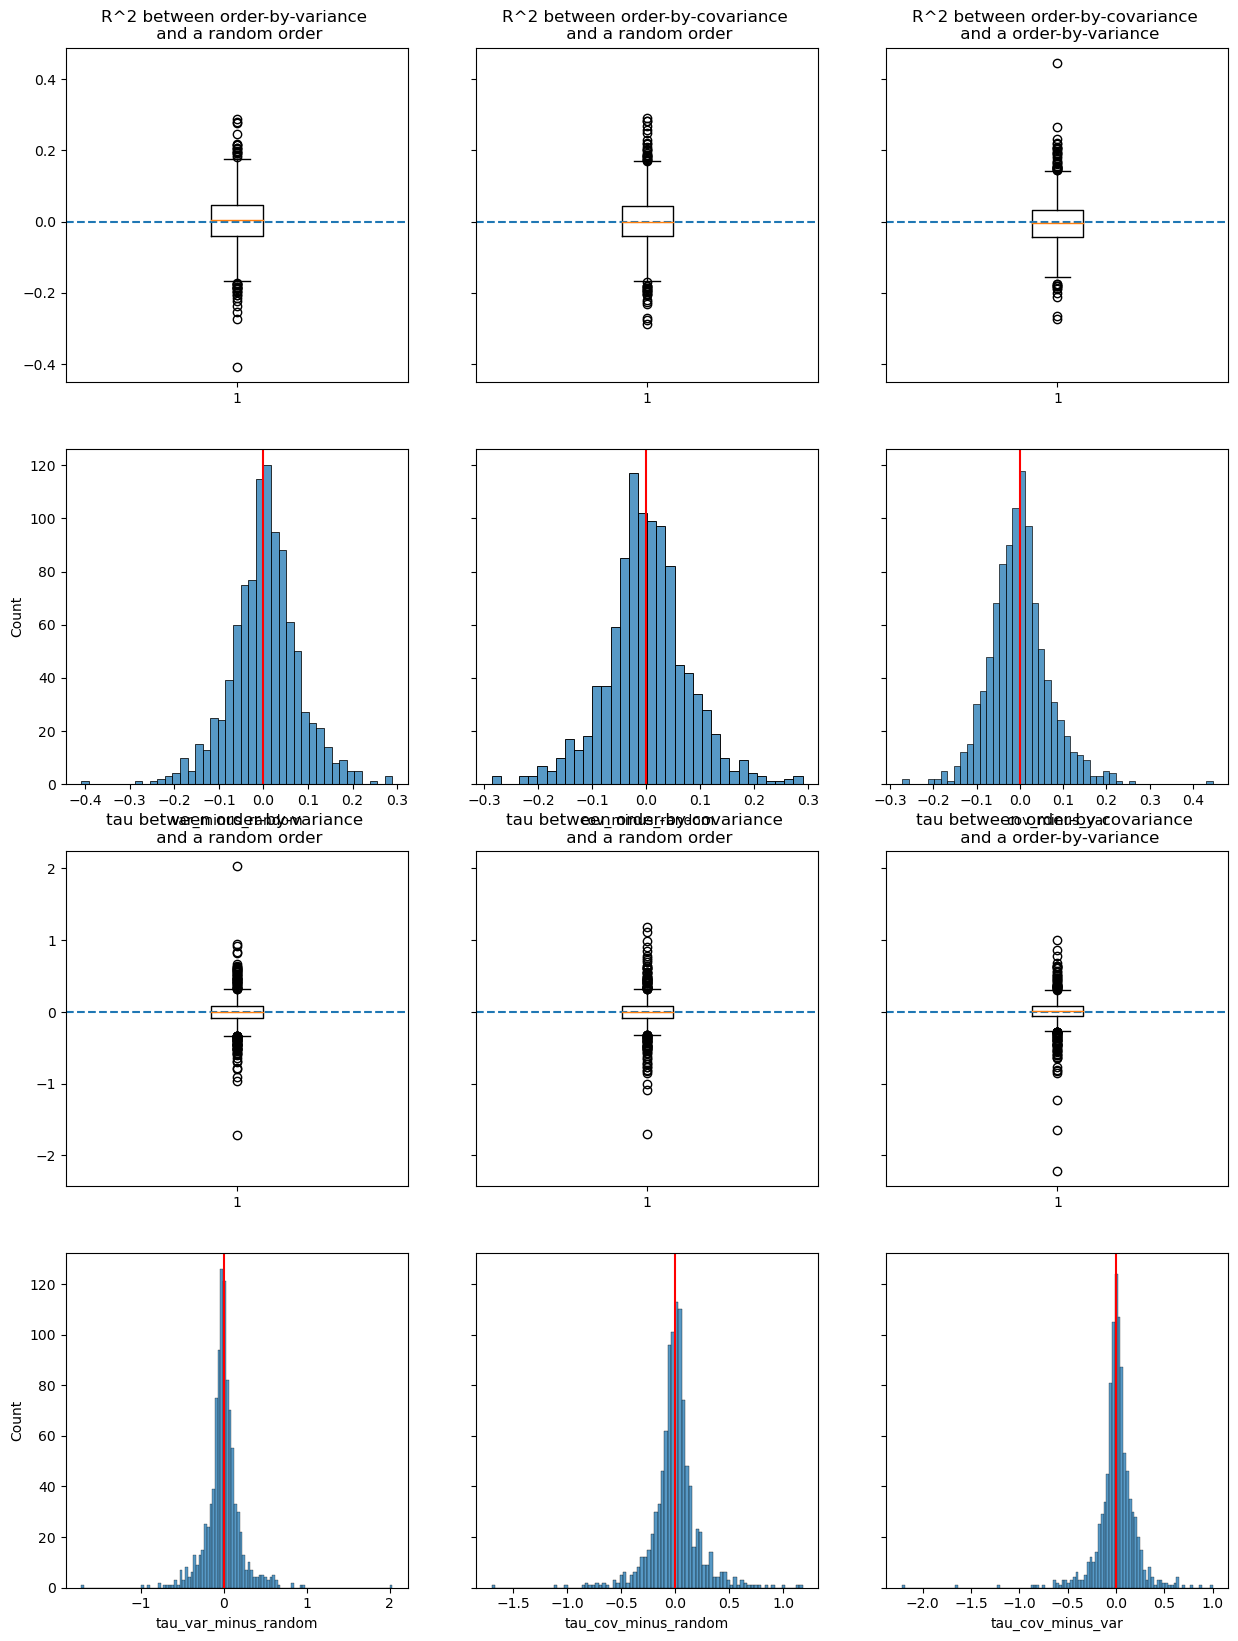

In [11]:
fig, ax = plt.subplots(4, 3, figsize = (15, 20), sharey = 'row')
ax[0,0].boxplot(result.var_minus_random)
ax[0,0].set_title('R^2 between order-by-variance \n and a random order')
ax[0,1].boxplot(result.cov_minus_random)
ax[0,1].set_title('R^2 between order-by-covariance \n and a random order')
ax[0,2].boxplot(result.cov_minus_var)
ax[0,2].set_title('R^2 between order-by-covariance \n and a order-by-variance')
for i in range(3):
    ax[0,i].axhline(0, linestyle = '--')
    ax[1,i].axvline(0, c = 'red')
sns.histplot(result.var_minus_random, ax = ax[1,0])
sns.histplot(result.cov_minus_random, ax = ax[1,1])
sns.histplot(result.cov_minus_var, ax = ax[1,2])
# for tau
ax[2,0].boxplot(result.tau_var_minus_random)
ax[2,0].set_title('tau between order-by-variance \n and a random order')
ax[2,1].boxplot(result.tau_cov_minus_random)
ax[2,1].set_title('tau between order-by-covariance \n and a random order')
ax[2,2].boxplot(result.tau_cov_minus_var)
ax[2,2].set_title('tau between order-by-covariance \n and a order-by-variance')
for i in range(3):
    ax[2,i].axhline(0, linestyle = '--')
    ax[3,i].axvline(0, c = 'red')
sns.histplot(result.tau_var_minus_random, ax = ax[3,0])
sns.histplot(result.tau_cov_minus_random, ax = ax[3,1])
sns.histplot(result.tau_cov_minus_var, ax = ax[3,2])
plt.savefig('orderplot4.png')
plt.show()

## 2. Do we need a tree model (Using Agglomerative Clustering)?

In [2]:
from estimators import ClusteredSegmentation

In [3]:
rg = RandomGenerator(10, 10000, order_by = 'var', use_dask = False, verbose= False)

In [29]:
cluster = ClusteredSegmentation(n_clusters = None)
result = cluster.find_result_from_RG(rg)

In [30]:
result, result.tau_est, result.tau_LB

(tau(n=10000, p=1024, q=46, r_sqf=0.5963001780386388, r_sqr=0.595604401849998, alpha=0.05),
 0.0017234988741397076,
 1.112136492758142e-16)

In [36]:
result = cluster.find_result_from_RG(rg, n_clusters = 10)
result, result.tau_est, result.tau_LB

(tau(n=10000, p=1024, q=10, r_sqf=0.5352463709065407, r_sqr=0.518914753623673, alpha=0.05),
 0.03514037601970721,
 1.149236679176221e-16)

# Wow......

## 3. Missing Barcodes (Unseen pairs)

When we observe missing barcodes, we may explore several options.   
First, when we strictly assume linearity of the model and follows the MLE principle, unseen pairs implies some of the parameter estimates in the linear regression model to be 0.    
*In the poisson regression setting, they are estimated to be 0 under the MLE principle.*   
Being free from those assumptions and principle, we can explore two other options.   
**First**, we can simply rely on the tree model and see which final node or leaf each missing barcode will ends up with. For example, if our dataset does not have any entry for \[0,0,1,0,1,0\], simply obtain the predicted value of it from the tree model.   
**Second**, for each we obtain similarity scores using one of the following: Euclidean distiance, Jesen-Shannon Divergence, and Mahalanobis distance.